# 淘宝行为数据分析

## 引入依赖包

In [103]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series

In [104]:
import matplotlib.pyplot as plt

In [105]:
%matplotlib inline

In [106]:
import pymysql

## 连接本地数据库和取数

In [107]:
db = pymysql.connect("localhost","root","17020144","taobao")

In [108]:
cursor = db.cursor()

In [109]:
cursor.execute("select * from user")

3734460

In [110]:
cursor.scroll(0,"absolute")

In [111]:
results = cursor.fetchall()

## 使用pandas进行数据分析和处理

In [112]:
data = pd.DataFrame(results,columns = ["userid","itemid","category","behaviour","time"])

In [113]:
data[:5]

,userid,itemid,category,behaviour,time
0,1,2268318,2520377,pv,20171125
1,1,2333346,2520771,pv,20171125
2,1,2576651,149192,pv,20171125
3,1,3830808,4181361,pv,20171125
4,1,4365585,2520377,pv,20171125


In [114]:
data["time"].value_counts()

20171202    518516
20171203    514937
20171201    407700
20171126    395921
20171130    390327
20171125    385147
20171129    380741
20171127    372435
20171128    368736
Name: time, dtype: int64

<AxesSubplot:title={'center':'Activity'}, xlabel='time'>

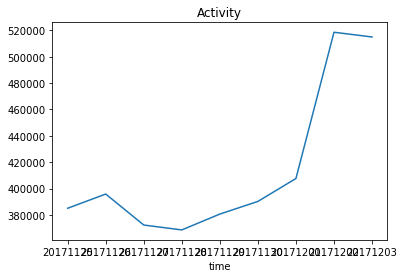

In [115]:
#观察用户的活跃图和购买趋势图
activ = data.groupby("time").count()["behaviour"]
activ.plot(title="Activity")

<AxesSubplot:title={'center':'buy'}, xlabel='time'>

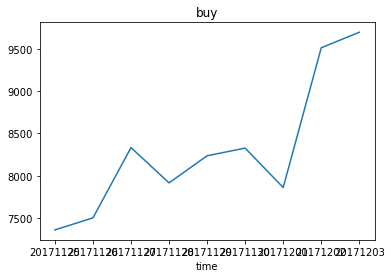

In [116]:
buy = data[data["behaviour"] == "buy"].groupby("time").count()["behaviour"]
buy.plot(title="buy")

In [117]:
#计算用户的购买分布,观察TopTen的购买情况
data[data["behaviour"]=="buy"]["userid"].value_counts()[:10]

234304     84
107932     72
122504     69
128379     65
190873     61
242650     61
1008380    57
165222     51
140047     47
1003983    43
Name: userid, dtype: int64

In [118]:
#根据用户的购买数量分布，观察长尾分布
usertail = data[data["behaviour"]=="buy"]["userid"].value_counts().sort_values(ascending=False)
usertail.index = range(len(usertail))

<AxesSubplot:title={'center':'user long tail'}>

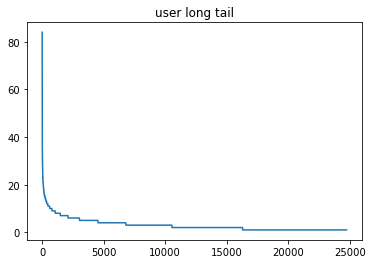

In [119]:
#做出用户的购买数量长尾分布
usertail.plot(title="user long tail")

In [120]:
#商品的销售趋势图


In [121]:
#同理可以找出商品的长尾分布
itemtail = data[data["behaviour"]=="buy"]["itemid"].value_counts().sort_values(ascending=False)
itemtail.index = range(len(itemtail))

<AxesSubplot:title={'center':'item long tail'}>

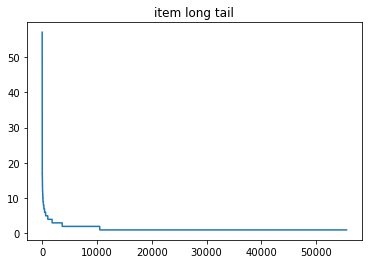

In [122]:
itemtail.plot(title = "item long tail")

In [138]:
##对数据进行行转列的处理
##转换为每一个用户对应其交互次数的表格
buy = []
for i in data["behaviour"]:
    if i == "buy":
        buy.append(1)
    else:
        buy.append(0)
pv = []
for i in data["behaviour"]:
    if i == "pv":
        pv.append(1)
    else:
        pv.append(0)
cart = []
for i in data["behaviour"]:
    if i == "cart":
        cart.append(1)
    else:
        cart.append(0)
favor = []
for i in data["behaviour"]:
    if i == "fav":
        favor.append(1)
    else:
        favor.append(0)

In [139]:
buy = Series(buy)
pv = Series(pv)
cart = Series(cart)
favor = Series(favor)

In [140]:
data["buy"] = buy
data["pv"] = pv
data["cart"] = cart
data["favor"] = favor

In [150]:
data.drop(["behaviour"],axis=1,inplace=True)

In [149]:
data[:5]

,userid,itemid,category,behaviour,time,buy,pv,cart,favor
0,1,2268318,2520377,pv,20171125,0,1,0,0
1,1,2333346,2520771,pv,20171125,0,1,0,0
2,1,2576651,149192,pv,20171125,0,1,0,0
3,1,3830808,4181361,pv,20171125,0,1,0,0
4,1,4365585,2520377,pv,20171125,0,1,0,0


In [159]:
aggData = data.groupby("userid").sum().sort_values("buy",ascending=False)

In [181]:
aggData["pv-buy"] = round(aggData["buy"]/aggData["pv"] * 100,4) 
aggData["cart-buy"] = round(aggData["buy"]/aggData["cart"] * 100,4)
aggData["pv-cart"]  = round(aggData["cart"]/aggData["pv"] * 100,4)

In [283]:
def toPercent(x):
    if np.isnan(x):
        return "0%"
    else:
        return str(round(x,2)) + "%"

In [189]:
aggData["pv-buy"] = aggData["pv-buy"].apply(toPercent,)
aggData["cart-buy"] = aggData["cart-buy"].apply(toPercent)
aggData["pv-cart"] = aggData["pv-cart"].apply(toPercent)

In [190]:
aggData[:5]

,buy,pv,cart,favor,pv-buy,cart-buy,pv-cart
userid,,,,,,,
234304,84,163,26,4,51.53%,323.08%,15.95%
107932,72,139,16,0,51.8%,450.0%,11.51%
122504,69,48,0,0,143.75%,inf%,0.0%
128379,65,0,0,1,inf%,inf%,nan%
242650,61,144,72,0,42.36%,84.72%,50.0%


<AxesSubplot:>

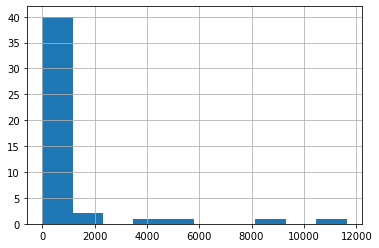

In [195]:
#观察购买数量分布的直方图
aggData["buy"].value_counts().hist()

In [202]:
##计算复购率
def multiple(x):
    if x > 1:
        return 1
    else:
        return 0

In [203]:
def buyOnce(x):
    if x >= 1:
        return 1
    else:
        return 0

In [224]:
data.drop(["pv-buy"],inplace=True,axis=1)

In [294]:
data.head()

,userid,itemid,category,time,buy,pv,cart,favor
0,1,2268318,2520377,20171125,0,1,0,0
1,1,2333346,2520771,20171125,0,1,0,0
2,1,2576651,149192,20171125,0,1,0,0
3,1,3830808,4181361,20171125,0,1,0,0
4,1,4365585,2520377,20171125,0,1,0,0


In [300]:
aggItem = data.groupby(["itemid","userid"]).sum()[["buy"]].sort_values("buy",ascending=False)

In [354]:
itemTable = aggItem.reset_index()

In [355]:
itemTable.head()

,index,itemid,userid,buy
0,0,4574184,140047,13
1,1,3894457,140047,12
2,2,2124040,118740,11
3,3,4157341,165053,8
4,4,4296993,118202,7


In [356]:
itemTable.drop(["index"],inplace=True,axis=1)

In [363]:
itemTable["MultiplePur"] = itemTable["buy"].apply(multiple)
itemTable["purchase"] = itemTable["buy"].apply(buyOnce)

In [364]:
itemTable["MultiplePur"].value_counts()

0    2830529
1       3098
Name: MultiplePur, dtype: int64

In [365]:
itemTable = itemTable.groupby("itemid").sum(["MutiplePur","purchase"])

In [368]:
itemTable["rePurchase"] = round(itemTable["MultiplePur"] / itemTable["purchase"] * 100,4)

In [369]:
itemTable["rePurchase"] = itemTable["rePurchase"].apply(toPercent)

In [370]:
itemTable.sort_values(by="rePurchase",ascending=False)

,buy,MultiplePur,purchase,rePurchase
itemid,,,,
265985,12,1,11,9.09%
1074025,12,1,11,9.09%
4848388,12,1,11,9.09%
4041131,12,1,11,9.09%
403792,12,1,11,9.09%
...,...,...,...,...
2592091,0,0,0,0%
2592093,0,0,0,0%
2592095,0,0,0,0%


In [372]:
data.head()

,userid,itemid,category,time,buy,pv,cart,favor
0,1,2268318,2520377,20171125,0,1,0,0
1,1,2333346,2520771,20171125,0,1,0,0
2,1,2576651,149192,20171125,0,1,0,0
3,1,3830808,4181361,20171125,0,1,0,0
4,1,4365585,2520377,20171125,0,1,0,0
